### Importing modules, functions, and libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.facecolor'] = '#ffffff'
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
!pip install opendatasets
import opendatasets as od

### Download the images

In [2]:
dataset_url = 'https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia'

In [3]:
# Downloading the Dataset
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mallishreeman
Your Kaggle Key: ··········


  0%|          | 0.00/2.29G [00:00<?, ?B/s]

100%|██████████| 2.29G/2.29G [01:03<00:00, 38.8MB/s]


In [4]:
# Assigning a variable to the dataset base directory
data_dir = './chest-xray-pneumonia/chest_xray/chest_xray/'

### Creating the training data set and validation data set

In [5]:
# Creating the training data set
train_tfms = tt.Compose([tt.Resize((64,64)), #Resizing all images to 64x64 pixels
                         tt.Grayscale(num_output_channels=1), #Converting the image to single channel
                         tt.RandomHorizontalFlip(), #Creating Random Flips
                         tt.ToTensor() #Converting the image to Tensor
                         ])
train_ds = ImageFolder(os.path.join(data_dir, 'train'), transform=train_tfms)

In [6]:
# Creating the validation data set
val_tfms = tt.Compose([tt.Resize((64,64)), #Resizing all images to 64x64 pixels
                         tt.Grayscale(num_output_channels=1), #Converting the image to single channel
                         tt.ToTensor() #Converting the image to Tensor
                         ])
val_ds = ImageFolder(os.path.join(data_dir, 'test'), transform=val_tfms)

### Data Exploration

In [7]:
train_ds[0]

(tensor([[[0.3686, 0.3843, 0.5412,  ..., 0.2392, 0.1098, 0.0784],
          [0.3569, 0.3686, 0.4706,  ..., 0.2118, 0.0863, 0.0784],
          [0.3412, 0.3608, 0.4078,  ..., 0.1804, 0.0745, 0.0824],
          ...,
          [0.0902, 0.0863, 0.0824,  ..., 0.1020, 0.1098, 0.1098],
          [0.1137, 0.1098, 0.1059,  ..., 0.1020, 0.1059, 0.1098],
          [0.2824, 0.2745, 0.2667,  ..., 0.1255, 0.1294, 0.1333]]]), 0)

In [8]:
train_ds[1][0].shape

torch.Size([1, 64, 64])

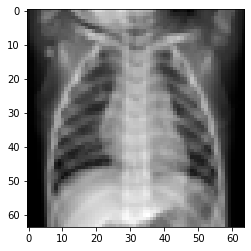

In [9]:

plt.imshow(train_ds[1][0][0], cmap = 'gray')

In [10]:
len(train_ds)

5216

In [11]:
len(val_ds)

624

In [12]:
train_ds.classes 

['NORMAL', 'PNEUMONIA']

### Creating the DataLoader for the training and the validation data

In [13]:
# Creating the DataLoaders
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory =True)
val_dl = DataLoader(train_ds, batch_size*2, num_workers = 2, pin_memory =True)

In [14]:
# Creating a function to visualize the batch
def display_batch(dl):
  for images,labels in dl:
    print(labels)
    fig,ax = plt.subplots(figsize = (12,6))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(images,nrow = 16 ).permute(1,2,0)  )
    break

tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 1])


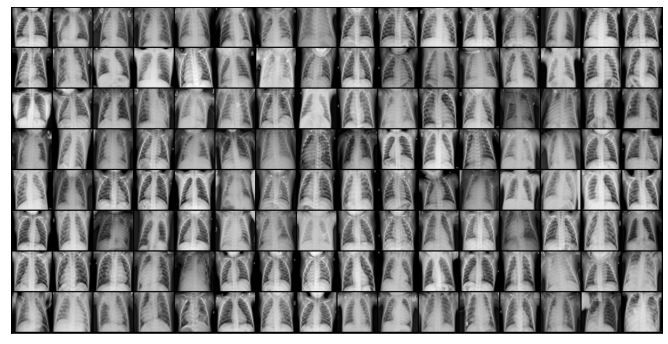

In [15]:
# Visualizing a batch
display_batch(train_dl)

### Creating the Model

In [16]:
# Creating a Image Classifier base
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
# Creating a convolutional block
# To be used in ResNet Model
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [18]:
# Creating a ResNet model
class ResNetModel(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(8), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

### Transfering the model and the data loaders to the GPU for faster training

In [21]:
def get_default_device():
    '''Returns cuda if GPU is present else cpu.'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Transfer tensor(s) and data to a chosen device."""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [22]:
# Checking if cuda device is available
device = get_default_device()
print(device)

cuda


In [23]:
# Instantiating ResNetModel and transfering it to GPU
model = to_device(ResNetModel(1, 2), device)

In [24]:
# Transfering the training and the validation data loader to the GPU
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

In [25]:
@torch.no_grad() # Preventing the gradient tracking for the evaluate function
# Function for evaluating the model
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

# Creating get_lr function to return the learning rate for learning rate scheduling
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Creating function for training the model
def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, grad_clip = None, weight_decay = 0,opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Instantiating OneCycleScheduler for a dynamic learning rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dl))
    for epoch in range(epochs):
      train_losses = []
      for batch in train_dl:
              loss = model.training_step(batch)
              train_losses.append(loss)
              loss.backward()
              
              # Gradient clipping
              if grad_clip: 
                  nn.utils.clip_grad_value_(model.parameters(), grad_clip)
              
              # Optimizing the model
              optimizer.step()
              optimizer.zero_grad()
              
              # Update learning rate
              sched.step()
      result = evaluate(model, val_dl)
      result['train_loss'] = torch.stack(train_losses).mean().item()
      model.epoch_end(epoch, result)
      history.append(result)
    return history

In [26]:
# Initially evaluating the model
evaluate(model, val_dl)

{'val_acc': 0.7505580186843872, 'val_loss': 0.6795861124992371}

In [27]:
# Choosing the hyper parameters
epochs = 18
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

### Training the model and recording the training loss, validation loss, and validation accuracy

In [28]:
%%time
history = []
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], train_loss: 0.5961, val_loss: 0.5600, val_acc: 0.7506
Epoch [1], train_loss: 0.4657, val_loss: 0.3966, val_acc: 0.8061
Epoch [2], train_loss: 0.3978, val_loss: 0.3715, val_acc: 0.8231
Epoch [3], train_loss: 0.3074, val_loss: 0.2572, val_acc: 0.8887
Epoch [4], train_loss: 0.2909, val_loss: 0.2046, val_acc: 0.9209
Epoch [5], train_loss: 0.2853, val_loss: 0.1882, val_acc: 0.9268
Epoch [6], train_loss: 0.1632, val_loss: 0.1437, val_acc: 0.9441
Epoch [7], train_loss: 0.1405, val_loss: 0.1342, val_acc: 0.9457
Epoch [8], train_loss: 0.1099, val_loss: 0.1214, val_acc: 0.9567
Epoch [9], train_loss: 0.1123, val_loss: 0.0770, val_acc: 0.9735
Epoch [10], train_loss: 0.0853, val_loss: 0.0613, val_acc: 0.9767
Epoch [11], train_loss: 0.0706, val_loss: 0.0485, val_acc: 0.9853
Epoch [12], train_loss: 0.0642, val_loss: 0.0573, val_acc: 0.9788
Epoch [13], train_loss: 0.0490, val_loss: 0.0341, val_acc: 0.9887
Epoch [14], train_loss: 0.0381, val_loss: 0.0265, val_acc: 0.9924
Epoch [15], train_lo

### Displaying the validation losses, training losses, and validation accuracies graphically

In [37]:
# Creating lists of val_acc and val_loss and train_loss
val_losses = [x['val_loss'] for x in history]
val_accs = [x['val_acc'] for x in history]
train_losses = [x['train_loss'] for x in history]

<function matplotlib.pyplot.show>

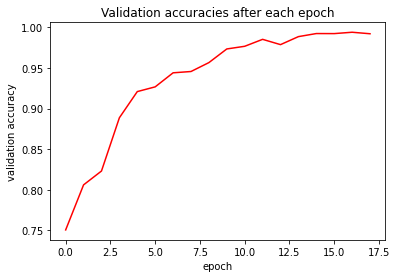

In [42]:
plt.title('Validation accuracies after each epoch')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.plot(list(range(len(val_accs))), val_accs, 'r')
plt.show

<function matplotlib.pyplot.show>

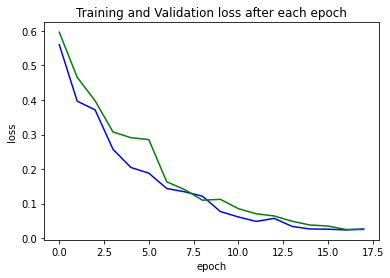

In [44]:
plt.title('Training and Validation loss after each epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(list(range(len(val_losses))), val_losses,'b')
plt.plot(list(range(len(train_losses))), train_losses, 'g')
plt.show

### Evaluating the model and predicting

In [32]:
# Function for predicting the class
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return train_ds.classes[preds[0].item()]

Label: NORMAL , Predicted: NORMAL


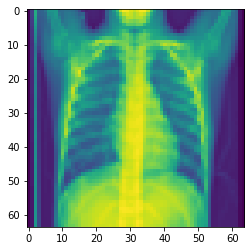

In [33]:
img, label = val_ds[100]
plt.imshow(img.permute(1, 2, 0)[:, :,0].clamp(0, 1))
print('Label:', val_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: PNEUMONIA , Predicted: PNEUMONIA


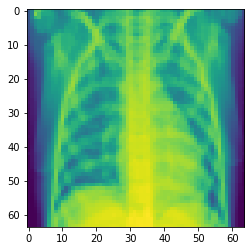

In [34]:
img, label = val_ds[500]
plt.imshow(img.permute(1, 2, 0)[:, :,0])
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [35]:
# Evaluation of the model based on val_dl
evaluate(model, val_dl)

{'val_acc': 0.9940476417541504, 'val_loss': 0.021815035492181778}

In [45]:
# creating testing DataLoader from the validation images folder 
test_ds = ImageFolder(os.path.join(data_dir, 'val/'))
test_dl = DataLoader(test_ds, 2 , shuffle = True)

In [46]:
# Evaluation of the model based on test_dl
evaluate(model, val_dl)

{'val_acc': 0.9938616156578064, 'val_loss': 0.023747431114315987}

### Saving the model

In [36]:
# Saving the model stats for further training and use
torch.save(model.state_dict(), 'PneumoniaDetectionResNet9.pth')